In [11]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (150, 150)

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

C:\Users\sihus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
def load_data():
    DIRECTORY = r"C:\dataset"
    CATEGORY = ["train", "test"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names.index(folder)
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output


In [14]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading train
Loading test


In [15]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('updated_model.h5')


Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,              # indicates our model
    clip_values=(0, 255)    # minimum and maximum values allowed for features
    )

In [18]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

In [19]:
def create_model():
    modelx = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    modelx.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return modelx


In [20]:
# Instantiating the model
modelx = create_model()

# Training the model
modelx.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)


Train on 14611 samples
Epoch 1/10
14611/14611 [==============================] - 183s 13ms/sample - loss: 20.6093 - accuracy: 0.3280
Epoch 2/10
14611/14611 [==============================] - 100s 7ms/sample - loss: 1.0886 - accuracy: 0.5288
Epoch 3/10
14611/14611 [==============================] - 100s 7ms/sample - loss: 1.1055 - accuracy: 0.5415
Epoch 4/10
14611/14611 [==============================] - 101s 7ms/sample - loss: 0.9425 - accuracy: 0.6119
Epoch 5/10
14611/14611 [==============================] - 102s 7ms/sample - loss: 0.8938 - accuracy: 0.6312
Epoch 6/10
14611/14611 [==============================] - 100s 7ms/sample - loss: 0.8291 - accuracy: 0.6700
Epoch 7/10
14611/14611 [==============================] - 100s 7ms/sample - loss: 0.7641 - accuracy: 0.6975
Epoch 8/10
14611/14611 [==============================] - 109s 7ms/sample - loss: 0.7054 - accuracy: 0.7225
Epoch 9/10
14611/14611 [==============================] - 109s 7ms/sample - loss: 0.7003 - accuracy: 0.7255
Epo

In [21]:
def candidate_data(test_images, test_labels, n):
    cx_test = []
    cy_test = []

    unique_classes = np.unique(test_labels)  # Get the unique classes in y_test
    
    for class_label in unique_classes:
        indices = np.where(test_labels == class_label)[0]  # Find indices where class_label occurs
        selected_indices = indices[:n]  # Select the first n indices

        cx_test.append(test_images[selected_indices].copy())
        cy_test.append(test_labels[selected_indices].copy())

    cx_test = np.concatenate(cx_test)
    cy_test = np.concatenate(cy_test)

    return cx_test, cy_test


In [22]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [23]:
def implement_attack(model, attack, sample_test, test_labels, attack_name):
    # Generate the adversarial examples
    x_test_adv = attack.generate(sample_test)
    performance_metrics = model.evaluate(x_test_adv, test_labels)
    predictions = model.predict(x_test_adv)

    # Convert 1-dimensional arrays to 2-dimensional
    if len(test_labels.shape) == 1:
        test_labels = np.expand_dims(test_labels, axis=1)
    if len(predictions.shape) == 1:
        predictions = np.expand_dims(predictions, axis=1)

    report = classification_report(
        np.argmax(test_labels, axis=1),
        np.argmax(predictions, axis=1),
        output_dict=True
    )

    report = report['weighted avg']
    report.update({'Loss': performance_metrics[0]})
    report.update({'Accuracy': performance_metrics[1]})
    report.update({'Attack': attack_name})

    return report, x_test_adv, predictions


In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier = KerasClassifier(model=model, 
                                    clip_values=(0, 255), channels_first=False)

In [26]:
from art.attacks.evasion import DeepFool

In [27]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [28]:
attack_deepf = DeepFool(classifier=artclassifier, max_iter=10, batch_size=20,epsilon=0.01)

In [29]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_deepf, sample_test=sample_test, test_labels=sample_label, attack_name='Deepfool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation


C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


DeepFool:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall

Adversarial test image
Actual label: CNV
Predicted label: DRUSEN


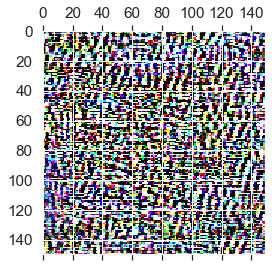

In [30]:
actual_label_index = test_labels[0]  
actual_label_name = class_names[actual_label_index]

predicted_label_index = np.argmax(predictions[0])
predicted_label_name = class_names[predicted_label_index]

print("Adversarial test image")
print("Actual label: {}".format(actual_label_name))
print("Predicted label: {}".format(predicted_label_name))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()


In [31]:
from art.estimators.classification import TensorFlowV2Classifier

In [45]:
artclassifierx = TensorFlowV2Classifier(model=modelx, nb_classes=4, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

In [46]:
gaussn_def(artclassifierx._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.5067974 , 0.04756445, 0.15566729, 0.10560397, 0.        ,
         0.06488321, 0.        , 0.        , 0.        , 0.11948361]],
       dtype=float32),
 0)

In [47]:
actual_accuracy = np.mean(np.argmax(predictions, axis=-1) == np.argmax(actual_label_name, axis=-1))
print("Actual accuracy:", actual_accuracy)


robust_accuracy = np.mean(np.argmax(predictions, axis=-1) == np.argmax(predicted_label_name, axis=-1))
print("Robust accuracy:", robust_accuracy)


Actual accuracy: 0.525
Robust accuracy: 0.525


In [52]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

In [53]:
artclassifierx = TensorFlowV2Classifier(model=modelx, nb_classes=4, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

In [54]:
hc_def(artclassifierx._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.9856784, 0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       ]], dtype=float32),
 0)

In [55]:
# evaluating the attack samples
perf =  artclassifierx._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [243.07774658203124, 0.325]


In [39]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

In [56]:
artclassifierx2 = TensorFlowV2Classifier(model=modelx, nb_classes=4, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

In [57]:
rs_def(artclassifierx2._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.23761216, 0.0321278 , 0.04743738, 0.05495947, 0.10464385,
         0.10464385, 0.10464385, 0.10464385, 0.10464385, 0.10464385]],
       dtype=float32),
 0)

In [58]:
# evaluating the attack samples
perf =  artclassifierx2._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [243.07774658203124, 0.325]


In [43]:
import matplotlib.pyplot as plt

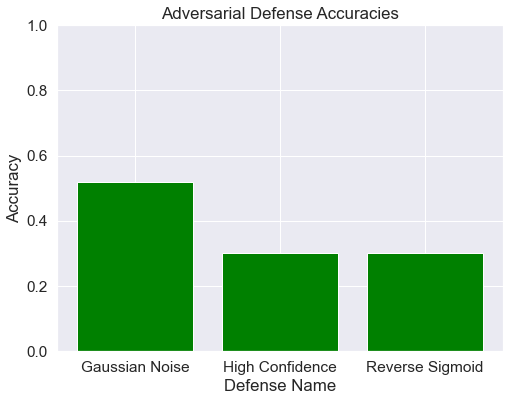

In [44]:
defense_names = ['Gaussian Noise', 'High Confidence', 'Reverse Sigmoid']
accuracies = [0.52, 0.30, 0.30]

plt.figure(figsize=(8, 6))
plt.bar(defense_names, accuracies, color='green')
plt.title('Adversarial Defense Accuracies')
plt.xlabel('Defense Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.show()
